In [1]:
import pandas as pd

In [2]:
from sentence_transformers import SentenceTransformer, models, InputExample, losses
from torch import nn
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, util

In [ ]:
#dataset: https://huggingface.co/datasets/stsb_multi_mt/viewer/en/train

from datasets import load_dataset
dataset = load_dataset("stsb_multi_mt", "en")

print(dataset)

In [132]:
dataset["train"]

Dataset({
    features: ['sentence1', 'sentence2', 'similarity_score'],
    num_rows: 5749
})

In [134]:
# assume that we have already loaded the dataset called "dataset"
for split, data in dataset.items():
    data.to_csv(f"stsb_multi_mt-dataset-{split}.csv", index = None)

Creating CSV from Arrow format: 100%|██████████| 2/2 [00:00<00:00, 242.17ba/s]


In [3]:
train = pd.read_csv("PATH/glue_mrpc-dataset-train.csv")
train.head()

,sentence1,sentence2,label,idx
0,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",1,0
1,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,0,1
2,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",1,2
3,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",0,3
4,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,1,4


In [4]:
val = pd.read_csv("PATH/glue_mrpc-dataset-validation.csv")
val.head()

,sentence1,sentence2,label,idx
0,He said the foodservice pie business doesn 't ...,""" The foodservice pie business does not fit ou...",1,9
1,Magnarelli said Racicot hated the Iraqi regime...,"His wife said he was "" 100 percent behind Geor...",0,18
2,"The dollar was at 116.92 yen against the yen ,...","The dollar was at 116.78 yen JPY = , virtually...",0,25
3,The AFL-CIO is waiting until October to decide...,The AFL-CIO announced Wednesday that it will d...,1,32
4,No dates have been set for the civil or the cr...,No dates have been set for the criminal or civ...,0,33


In [173]:
test = pd.read_csv("PATH/stsb_multi_mt-dataset-test.csv")


In [ ]:
val['label'] = val['label'].astype(float)
train['label'] = train['label'].astype(float)
test['label'] = test['label'].astype(float)

### Fine Tuned Model

In [ ]:
word_embedding_model = models.Transformer('distilbert-base-uncased', max_seq_length=128)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


In [42]:
# create evaluation

evaluator_val = EmbeddingSimilarityEvaluator(list(val.sentence1), 
                                         list(val.sentence2), 
                                         list(val.label),
                                         name='sts-dev')

In [43]:
# train 
tr_data   = [InputExample(texts=[s[0], s[1]],  label = [s[2]] ) \
                 for s in list(train[ ['sentence1', 'sentence2', 'label'] ].drop_duplicates().values)]

In [46]:
train_dataloader = DataLoader(tr_data, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)

In [ ]:
#Fine-Tuned the model:
model_path = "PATH/model"
model.fit(train_objectives=[(train_dataloader, train_loss)], 
          
          evaluator = evaluator_val,  evaluation_steps=100,
          epochs=5, warmup_steps=500,optimizer_params={'lr': 2e-2},
          show_progress_bar=True, 
          save_best_model = True,
          output_path=model_path)

### Loading fine-Tuned Model

In [175]:
model = SentenceTransformer("PATH/model")

In [176]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [177]:
embeddings1 = model.encode(test["sentence1"].to_list(), convert_to_tensor=True)
embeddings2 = model.encode(test["sentence2"].to_list(), convert_to_tensor=True)

In [178]:
test["embedding_sentence1"] = [t.numpy() for t in embeddings1]
test["embedding_sentence2"] = [t.numpy() for t in embeddings2]

In [179]:
#adding embeddings
df1 = pd.DataFrame(test['embedding_sentence1'].tolist(), index= test.index).add_prefix('sentence1_embedding_').fillna('')
df2 = pd.DataFrame(test['embedding_sentence2'].tolist(), index= test.index).add_prefix('sentence2_embedding_').fillna('')

test = test.join(df1)
test = test.join(df2)

In [181]:
#Output the pairs with their score
#Compute cosine-similarities

cosine_scores = util.cos_sim(embeddings1, embeddings2)
cosine_similarity = []
for i in range(len(test.sentence1)):
    cosine_similarity.append(cosine_scores[i][i].numpy())

test['cosine_similarity'] = cosine_similarity
    

In [205]:
test.head()

,sentence1,sentence2,similarity_score,embedding_sentence1,embedding_sentence2,sentence1_embedding_0,sentence1_embedding_1,sentence1_embedding_2,sentence1_embedding_3,sentence1_embedding_4,...,sentence2_embedding_760,sentence2_embedding_761,sentence2_embedding_762,sentence2_embedding_763,sentence2_embedding_764,sentence2_embedding_765,sentence2_embedding_766,sentence2_embedding_767,cosine_similarity,normalize_cosine_similarity
0,A girl is styling her hair.,A girl is brushing her hair.,2.5,"[0.29114142, -0.4535064, -0.2336297, -0.060415...","[0.20029347, -0.43080962, -0.25721815, -0.0933...",0.291141,-0.453506,-0.233630,-0.060416,0.345427,...,0.114110,-0.254553,-0.012635,-0.181735,-0.048329,-0.520970,0.119131,-0.096987,0.9938881,4.96944
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.6,"[0.11425072, -0.10386596, -0.37226626, -0.0085...","[0.13974287, -0.13874765, -0.32828426, 0.00908...",0.114251,-0.103866,-0.372266,-0.008557,0.354328,...,-0.030770,-0.158675,-0.175116,-0.135144,-0.231277,-0.451960,0.133813,-0.272363,0.99287784,4.964389
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.0,"[0.063438155, -0.3298023, -0.3007227, -0.10424...","[0.012412683, -0.40886432, -0.27465093, -0.117...",0.063438,-0.329802,-0.300723,-0.104240,0.164086,...,0.080420,-0.264386,-0.007247,-0.309622,0.013972,-0.509904,0.062374,-0.105778,0.9908508,4.954254
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.2,"[0.040492628, -0.25955483, -0.35974133, 0.0179...","[-0.002026867, -0.29833025, -0.36179078, 0.013...",0.040493,-0.259555,-0.359741,0.017904,0.328225,...,0.022953,-0.143547,0.110926,-0.053076,-0.071818,-0.231033,0.169862,-0.004567,0.99579525,4.978976
4,A man is playing a harp.,A man is playing a keyboard.,1.5,"[0.15854508, -0.07991676, -0.3511108, -0.07165...","[-0.012954507, -0.13547927, -0.31662795, -0.05...",0.158545,-0.079917,-0.351111,-0.071651,0.255848,...,0.114440,-0.166727,0.090447,-0.020665,0.074338,-0.423784,0.187310,-0.159755,0.9917424,4.958712


#### PCA

In [146]:
from pandas import read_csv
from sklearn.decomposition import PCA

X = test[test.columns[6:]].drop(["cosine_similarity"], axis = 1)
pca = PCA(n_components=100)
fit = pca.fit(X)

In [147]:
fit.explained_variance_ratio_.sum()

0.8234266

In [148]:
fit.explained_variance_ratio_

array([0.19347052, 0.10685216, 0.05434227, 0.02662614, 0.02207576,
       0.01897466, 0.01739105, 0.01520962, 0.01415205, 0.01322376,
       0.01205466, 0.01159548, 0.01035808, 0.01013825, 0.00912039,
       0.00880299, 0.00868797, 0.0084055 , 0.00811711, 0.00785718,
       0.00752256, 0.0067913 , 0.00653185, 0.00635386, 0.00606918,
       0.005919  , 0.00577255, 0.00567197, 0.00543776, 0.00534838,
       0.00494511, 0.00483001, 0.00474324, 0.00465312, 0.00449277,
       0.0043943 , 0.00435253, 0.00401442, 0.00390515, 0.00381124,
       0.00374282, 0.00367649, 0.00361936, 0.00343841, 0.00340538,
       0.0033668 , 0.00335892, 0.00330388, 0.0032347 , 0.0031181 ,
       0.00305991, 0.00301396, 0.00297304, 0.00283746, 0.00282562,
       0.00280032, 0.00275744, 0.00268586, 0.0026369 , 0.00258807,
       0.00254188, 0.0025119 , 0.00247052, 0.00243483, 0.00240522,
       0.00238345, 0.00235724, 0.00232083, 0.00227932, 0.00224634,
       0.00223018, 0.00217877, 0.00215971, 0.00212265, 0.00209

In [149]:
abs( fit.components_ )

array([[0.00142813, 0.03237195, 0.00384801, ..., 0.02873803, 0.01096036,
        0.02108203],
       [0.01467494, 0.01652079, 0.00999698, ..., 0.03564297, 0.00365134,
        0.02391429],
       [0.01342187, 0.04391203, 0.04222296, ..., 0.03755064, 0.02259941,
        0.01116349],
       ...,
       [0.05210344, 0.00350186, 0.00910571, ..., 0.0091806 , 0.00621142,
        0.01995474],
       [0.00498588, 0.06494679, 0.01962913, ..., 0.02859476, 0.01851166,
        0.02392749],
       [0.02734253, 0.04702285, 0.01874241, ..., 0.03025533, 0.02012021,
        0.00966196]], dtype=float32)

In [150]:
abs( fit.components_ )[0]

array([0.00142813, 0.03237195, 0.00384801, ..., 0.02873803, 0.01096036,
       0.02108203], dtype=float32)

In [151]:
abs( fit.components_ )[0].shape

(1535,)

In [152]:
abs( fit.components_ ).shape

(100, 1535)

In [153]:
keys = X.columns.to_list()
values = (abs( fit.components_ )[0]).tolist()
pca_importance = dict(zip(keys, values))

In [ ]:
sorted(pca_importance.items(), key=lambda x:x[1], reverse=True)[:10]

In [155]:
selected_features = ['sentence2_embedding_197',
 'sentence1_embedding_197', 
 'sentence2_embedding_287', 
 'sentence2_embedding_355', 
 'sentence1_embedding_287', 
 'sentence2_embedding_445',
 'sentence1_embedding_121', 
 'sentence1_embedding_355', 
 'sentence1_embedding_445']

### XGBoost MODEL

In [71]:
test["normalize_cosine_similarity"] = 5 * (test["cosine_similarity"]-1) +5

In [183]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

In [210]:
X = test[['sentence2_embedding_197',
 'sentence1_embedding_197', 
 'sentence2_embedding_287', 
 'sentence2_embedding_355', 
 'sentence1_embedding_287', 
 'sentence2_embedding_445',
 'sentence1_embedding_121', 
 'sentence1_embedding_355', 
 'sentence1_embedding_445', 'normalize_cosine_similarity']] 
X = X.astype(float)

y = test["similarity_score"]

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# create an xgboost regression model
model = XGBRegressor()

In [213]:
#Hyper Parameter Tuned with Grid Search
param_grid = {"max_depth":    [4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}


search = GridSearchCV(model, param_grid, cv=5).fit(X_train, y_train)
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}


In [214]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],)

regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)

In [215]:
from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt( mean_squared_log_error(y_test, predictions) )
print("The score is %.5f" % RMSLE )

The score is 0.43445


In [216]:
from sklearn.metrics import mean_squared_error
ypred = regressor.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 1.45
RMSE: 1.20


In [217]:
#WITHOUT Embeddings just with Cosine Similarity Score:
RMSLE = np.sqrt( mean_squared_log_error(y_test, X_test.normalize_cosine_similarity) )
print("The score is %.5f" % RMSLE )

The score is 0.81306


In [219]:
#WITHOUT Embeddings just with Cosine Similarity Score:
ypred = regressor.predict(X_test)
mse = mean_squared_error(y_test,  X_test.normalize_cosine_similarity)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 7.46
RMSE: 2.73


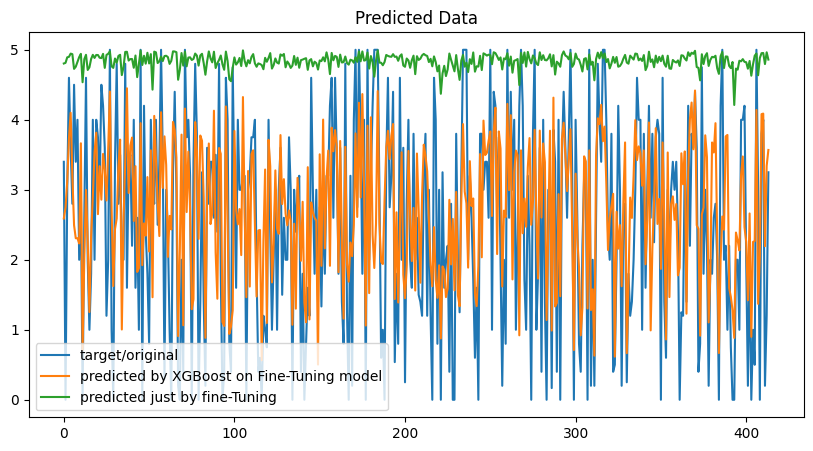

In [232]:
import matplotlib.pyplot as plt 

x_ax = range(len(y_test))
plt.figure(figsize=(10,5))
plt.plot(x_ax, y_test, label="target/original")
plt.plot(x_ax, predictions, label="predicted by XGBoost on Fine-Tuning model")
plt.plot(x_ax, X_test.normalize_cosine_similarity, label="predicted just by fine-Tuning")
plt.title("Predicted Data")
plt.legend()

plt.show()